# Introduction
This notebook is target to train a model to identify if a person is wearing a face mask and a safety helmet.

The dataset is small, with 308 images, and around 1800 detected face.

Target plan as below:
1. Try the basic transfer learning using Resnet-18
2. Leverage YOLO-v5 for the attempt 

In [1]:
# Import basic library
import os
import cv2
import random
import numpy as np
from lxml import etree
from tqdm import tqdm
from PIL import Image
import cv2 
from scipy import stats

from IPython.display import display

# Annotation extraction and image chop

In [2]:
IMAGE_SRC = '../dataset/images'
ANNOTATION_FILE = '../dataset/annotations.xml'

img_list = [f for f in os.listdir(IMAGE_SRC) if os.path.isfile(os.path.join(IMAGE_SRC, f))]
root = etree.parse(ANNOTATION_FILE).getroot()

dataset = []

for img_name in img_list:
    img = cv2.imread(os.path.join(IMAGE_SRC, img_name))
    img_id = img_name.split('.')[0]
    image_name_attr = ".//image/[@id='{}']".format(img_id)
    for image_tag in root.iterfind(image_name_attr):
        image = {}
        for key, value in image_tag.items():
            image[key] = value
        for box_tag in image_tag.iter('box'):
            box = {'image_id': img_id, 'img_name': img_name}
            for key, value in box_tag.items():
                box[key] = round(float(value)) if key in ['xbr', 'xtl', 'ybr', 'ytl'] else value
            box['width'] = float(box['xbr']) - float(box['xtl']) 
            box['height'] = float(box['ybr']) - float(box['ytl'])
            box['cropped_image'] = img[ box['ytl']: box['ybr'], box['xtl']:box['xbr']]
            if box['label'] == 'head':
                for attribute_tag in box_tag.iter('attribute'): 
                    if attribute_tag.attrib['name'] == 'has_safety_helmet':
                        box['helmet_label'] = attribute_tag.text
                    if attribute_tag.attrib['name'] == 'mask':
                        box['mask_label'] = attribute_tag.text
                dataset.append(box)


## Select random sample for exploration

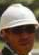

Helmet:  yes
Mask:  no
Image Width - Height: 39.0 55.0


In [3]:
def view_sample(data: dict):
    img = cv2.cvtColor( data['cropped_image'], cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))
    print('Helmet: ', data.get('helmet_label', None))
    print('Mask: ', data.get('mask_label', None))
    print('Image Width - Height: {} {}'.format(data['width'], data['height']))

def sample_picker(dataset, sample_id):
    data = dataset[sample_id] 
    view_sample(data)

sample_picker(dataset, sample_id = random.randint(0, len(dataset)))

# Exploratory Data Analysis

Length of dataset: 1792
Helmet Class distribution: {'yes': 1170, 'no': 622}
Mask Class distribution: {'yes': 494, 'no': 428, 'invisible': 869, 'wrong': 1}


Width DescribeResult(nobs=1792, minmax=(2.0, 1044.0), mean=31.303571428571427, variance=2503.673287070272, skewness=8.227933571175695, kurtosis=116.71127548341272) 

Height DescribeResult(nobs=1792, minmax=(2.0, 1012.0), mean=37.22377232142857, variance=3106.8594457281447, skewness=6.442690011010237, kurtosis=71.04713182089796) 

Ratio DescribeResult(nobs=1792, minmax=(0.5, 3.383177570093458), mean=1.1926839252653214, variance=0.06216621687743987, skewness=1.5830528358306917, kurtosis=9.701898175784155) 

Area DescribeResult(nobs=1792, minmax=(8.0, 1056528.0), mean=3879.4391741071427, variance=859915836.6127135, skewness=27.429987278127957, kurtosis=936.1386429873853) 



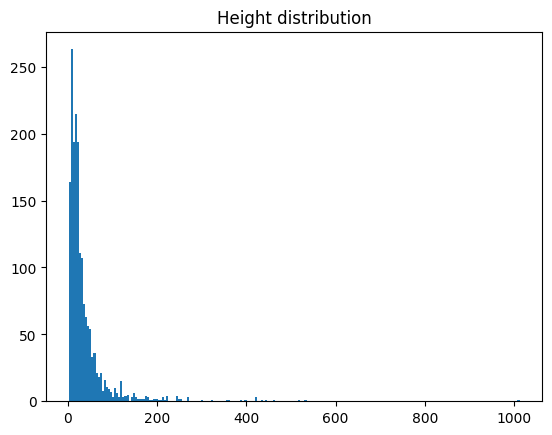

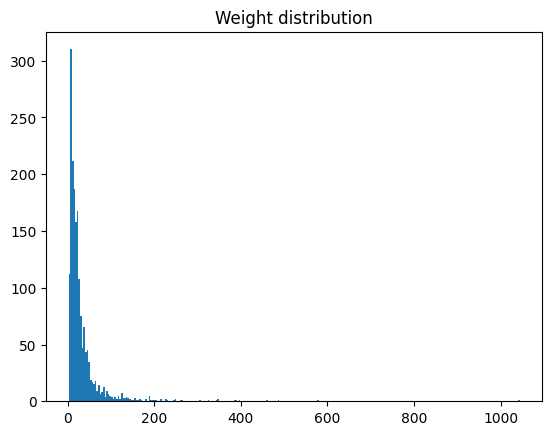

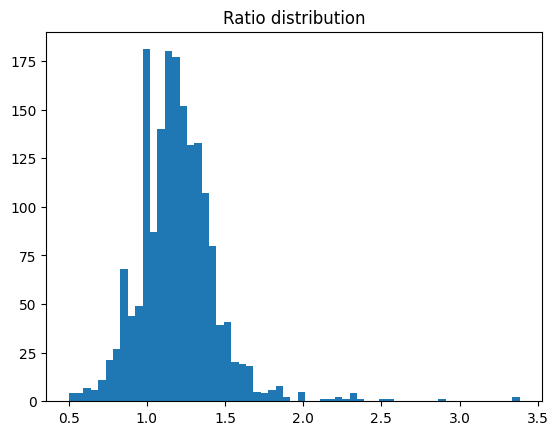

In [24]:
# Length of Dataset
print('Length of dataset: {}'.format(len(dataset)))

# Class distribution
helmet_stat = {}
mask_stat = {}
for data in dataset:
    helmet_stat[data.get('helmet_label', 'None')] = helmet_stat.get(data.get('helmet_label', 'None'), 0) + 1
    mask_stat[data.get('mask_label', 'None')] = mask_stat.get(data.get('mask_label', 'None'), 0) + 1
print('Helmet Class distribution:', helmet_stat)
print('Mask Class distribution:', mask_stat)
print('\n')

# Size distribution
width_list = ([data['width'] for data in dataset])
height_list = ([data['height'] for data in dataset])
hw_scale_list = ([data['height'] /data['width'] for data in dataset])
area_list = ([data['width'] * data['height'] for data in dataset])

print('Width', stats.describe(width_list), "\n")
print('Height', stats.describe(height_list), "\n")
print('Ratio', stats.describe(hw_scale_list), "\n")
print('Area', stats.describe(area_list), "\n")

import matplotlib.pyplot as plt

rng = np.array(height_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Height distribution")
plt.show()

rng = np.array(width_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Weight distribution")
plt.show()


rng = np.array(hw_scale_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Ratio distribution")
plt.show()

## Special Data
A single  label for "Wrong" Mask 

wrong


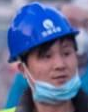

Helmet:  yes
Mask:  wrong
Image Width - Height: 88.0 112.0


In [15]:
special_data = []
for data in dataset:
    if data.get('mask_label', 'None') in [ 'wrong']:
        print(data.get('mask_label', 'None'))
        special_data.append(data)
        view_sample(data)



# Data Cleansing & Transformation

# Data split (Skip first, by overfit the dataset to prove)

# Naiive Model Benchmark

# Transferring Learning from Resnet-18
## https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Train Custom Data for YOLO V5
## https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data